In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xgboost as xg
from tqdm import tqdm
import glob
import seaborn as sns
import cv2
import io
from PIL import Image
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import ipywidgets as widgets
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

2024-02-20 15:14:09.189241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 15:14:09.189375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 15:14:09.369831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import tensorflow.keras
from tensorflow.keras import layers
# from tensorflow.keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_imgs(path):
    folders=os.listdir(path)
    data = []
    age=[]
    gender = []
    ethnicity =[]
#     folders.remove('dataset')
    for i in tqdm(folders):
            im=Image.open(path+'/'+i).convert('RGB')
            im=im.resize((48,48))
            ar=np.array(im)
            data.append(ar)
            age.append(int(i.split('_')[0]))
            gender.append(int(i.split('_')[1]))
            ethnicity.append(int(i.split('_')[-2]))
#     t=pd.factorize(np.array(label))
   # print(t)
#     tgt=t[0]
    return np.array(data),np.array(age),np.array(gender),np.array(ethnicity)

In [4]:
gender=[ 'male', 'female']
ethnicity = ['white', 'black', 'asian', 'indian', 'other']

In [5]:
x,y_age,y_gender,y_ethnicity = load_imgs('/kaggle/input/utkface-new/UTKFace')

100%|██████████| 23708/23708 [02:35<00:00, 152.16it/s]


In [6]:
# Assuming x, y_gender, y_ethnicity, and y_age are your features and labels
x_train, x_test, y_train_gender, y_test_gender, y_train_ethnicity, y_test_ethnicity, y_train_age, y_test_age = train_test_split(
    x, y_gender, y_ethnicity, y_age,
    test_size=0.1,
    random_state=100
)


# Hyper parameters

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 300  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

## Data Augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

(-0.5, 47.5, 47.5, -0.5)

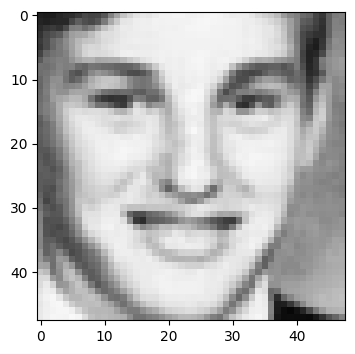

In [9]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("ON")

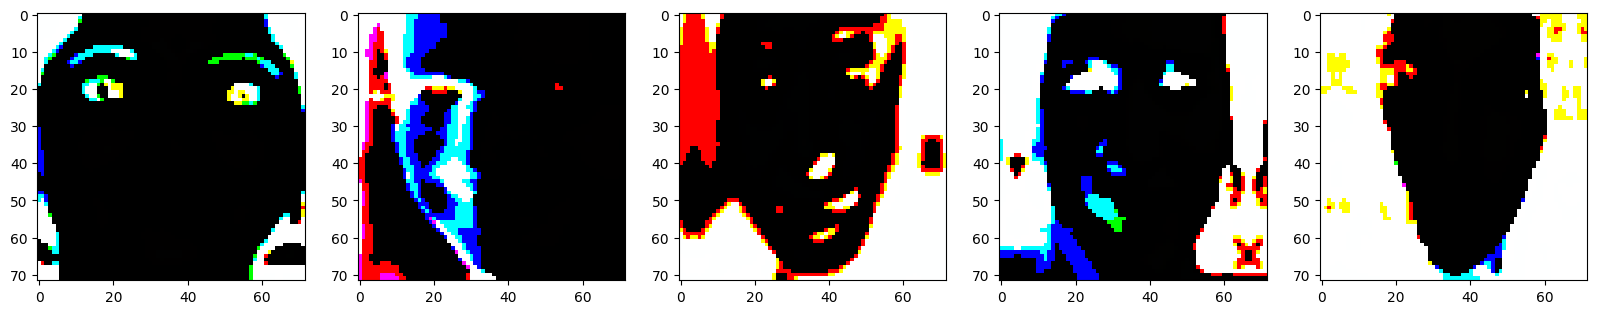

In [10]:
# Generate augmented images
augmented_images = data_augmentation(x_train)

# Plot a few augmented images
num_images = 5
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(num_images):
    axes[i].imshow(augmented_images[i*10].numpy().astype("uint8"))
plt.show()

## building mlp layer

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch Maker

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


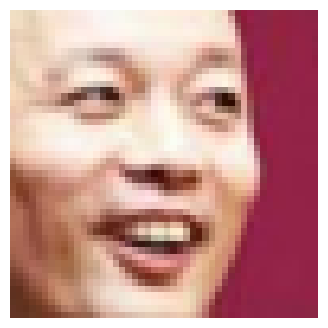

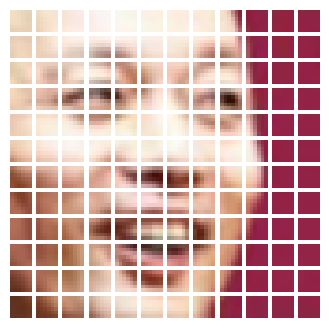

In [13]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Patch Encoder

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Building Vision Transformer

In [15]:
input_shape = (48,48,3)
num_ethnicities = 5

### Building Vision Transformer

# coordinate attention layer

In [46]:
class CoordinateAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, dropout=0.0):
        super(CoordinateAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.num_patches = input_shape[1]
        self.projection_dim = input_shape[-1]
        self.query_dense = layers.Dense(self.key_dim, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key_dense = layers.Dense(self.key_dim, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value_dense = layers.Dense(self.projection_dim, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.dropout_layer = layers.Dropout(self.dropout)
        super().build(input_shape)

    def call(self, inputs):
        # Splitting the input into queries, keys, and values
        q = self.query_dense(inputs)
        k = self.key_dense(inputs)
        v = self.value_dense(inputs)

        # Getting the position encodings
        position_encodings = self.position_encoding(self.num_patches, self.key_dim)

        # Adding position encodings to keys
        k = k + position_encodings

        # Scaled dot-product attention
        attention_logits = tf.matmul(q, k, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.key_dim, dtype=tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        attention_weights = self.dropout_layer(attention_weights)

        # Weighted sum of values
        output = tf.matmul(attention_weights, v)
        return output

    def position_encoding(self, n_patches, key_dim):
        angle_rads = self.get_angles(np.arange(n_patches)[:, np.newaxis], np.arange(key_dim)[np.newaxis, :], key_dim)
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, position, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return position * angle_rates


# cbam

In [47]:
# import tensorflow as tf
# from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
# from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

# def channel_attention_module(x, ratio=8):
#     batch, height, width, channel = x.shape.as_list()

#     ## Shared layers
#     l1 = Dense(channel//ratio, activation="relu", use_bias=False)
#     l2 = Dense(channel, use_bias=False)

#     ## Global Average Pooling
#     x1 = GlobalAveragePooling2D()(x)
#     x1 = l1(x1)
#     x1 = l2(x1)

#     ## Global Max Pooling
#     x2 = GlobalMaxPooling2D()(x)
#     x2 = l1(x2)
#     x2 = l2(x2)

#     ## Add both the features and pass through sigmoid
#     feats = x1 + x2
#     feats = Activation("sigmoid")(feats)
#     feats = Multiply()([x, feats])

#     return feats

# def spatial_attention_module(x):
#     ## Average Pooling
#     x1 = tf.reduce_mean(x, axis=-1)
#     x1 = tf.expand_dims(x1, axis=-1)

#     ## Max Pooling
#     x2 = tf.reduce_max(x, axis=-1)
#     x2 = tf.expand_dims(x2, axis=-1)

#     ## Concatenat both the features
#     feats = Concatenate()([x1, x2])
#     ## Conv layer
#     feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
#     feats = Multiply()([x, feats])

#     return feats

# def cbam_module(x):
#     x = tf.expand_dims(x, axis=-1)
#     x = channel_attention_module(x)
#     x = spatial_attention_module(x)
#     return x


In [54]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Apply CBAM module.
        attention_output =CoordinateAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.3)(x1)
#         x1 = tf.squeeze(attention_output, axis=-1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dense(256, activation='relu')(representation)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    
    # Age prediction branch
    age_branch = layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
    age_branch = layers.BatchNormalization()(age_branch)
    age_branch = layers.Dropout(0.1)(age_branch)
    age_output = layers.Dense(1, activation='linear', name='age_output')(age_branch)  # Assuming age is a regression task

    # Gender prediction branch
#     gender_branch = layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
#     gender_branch = layers.BatchNormalization()(gender_branch)
#     gender_branch = layers.Dropout(0.1)(gender_branch)
    gender_branch = layers.Dense(256, activation = LeakyReLU(alpha=0.3))(features)
    gender_branch = layers.BatchNormalization()(gender_branch)
    gender_branch = layers.Dropout(0.1)(gender_branch)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

    # Ethnicity prediction branch
#     ethnicity_branch = layers.Dense(256, activation =  LeakyReLU(alpha=0.3))(features)
#     ethnicity_branch = layers.BatchNormalization()(ethnicity_branch)
#     ethnicity_branch = layers.Dropout(0.1)(ethnicity_branch)
    ethnicity_branch = layers.Dense(100, activation =  keras.activations.gelu)(features)
    ethnicity_branch = layers.BatchNormalization()(ethnicity_branch)
    ethnicity_branch = layers.Dropout(0.3)(ethnicity_branch)
    ethnicity_output = layers.Dense(num_ethnicities, activation='softmax', name='ethnicity_output')(ethnicity_branch)

    # Create the Keras model with multiple outputs
    model = keras.Model(inputs=inputs, outputs=[age_output, gender_output, ethnicity_output])
    return model

### Compiling Model

In [55]:
class MultiTaskEstimator:
    _estimator_type = ''
    classes_ = {'age': None, 'gender': None, 'ethnicity': None}

    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'multi-task classifier'
        self.classes_['age'] = age_classes
        self.classes_['gender'] = gender_classes
        self.classes_['ethnicity'] = ethnicity_classes

    def predict(self, X):
        # Assuming your model returns a list of predictions for each output branch
        predictions = self.model.predict(X)

        # Apply threshold for binary classification (e.g., gender prediction)
        gender_threshold = 0.5
        gender_pred = (predictions[1] > gender_threshold).astype(int)

        # For age prediction, keep it as is
        age_pred = predictions[0]

        # For ethnicity prediction, find the class with the highest probability
        ethnicity_pred = predictions[2].argmax(axis=1)

        return age_pred, gender_pred, ethnicity_pred


In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def run_multi_task_experiment(model):
    optimizer = tf.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss={
            'age_output': keras.losses.MeanSquaredError(),
            'gender_output': keras.losses.BinaryCrossentropy(),
            'ethnicity_output': keras.losses.SparseCategoricalCrossentropy(),
        },
        metrics={
            'age_output': 'mae',
            'gender_output': 'accuracy',
            'ethnicity_output': 'accuracy',
        },
    )

    checkpoint_filepath = "/kaggle/working/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_gender_output_accuracy",  # Monitoring the gender accuracy for saving the best model
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y={'age_output': y_train_age, 'gender_output': y_train_gender, 'ethnicity_output': y_train_ethnicity},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    model.save('./model.h5')
    model.load_weights('./model.h5')
    
    # Evaluate the model on the test set
    evaluation = model.evaluate(x_test, {'age_output': y_test_age, 'gender_output': y_test_gender, 'ethnicity_output': y_test_ethnicity})
    
    print(f"Test age MAE: {evaluation[1]}")
    print(f"Test gender accuracy: {evaluation[5]}")
    print(f"Test ethnicity accuracy: {evaluation[6]}")
    
    # Predictions for each task
    y_pred_age, y_pred_gender, y_pred_ethnicity = model.predict(x_test)
    y_pred_gender = np.round(y_pred_gender)
    y_pred_ethnicity= np.argmax(y_pred_ethnicity, axis=1)
    
    # Additional evaluation metrics
    precision_gender = precision_score(y_test_gender, y_pred_gender)
    recall_gender = recall_score(y_test_gender, y_pred_gender)
    f1_gender = f1_score(y_test_gender, y_pred_gender)
    print("Gender Precision:", precision_gender)
    print("Gender Recall:", recall_gender)
    print("Gender F1 Score:", f1_gender)
    
    # Precision, Recall, and F1 for Ethnicity
    precision = precision_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    recall = recall_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    f1 = f1_score(y_test_ethnicity, y_pred_ethnicity, average='macro')
    print("Ethnicity Precision:", precision)
    print("Ethnicity Recall:", recall)
    print("Ethnicity F1 Score:", f1)
    # Assuming y_true and y_pred are your true and predicted regression values
    mae = mean_absolute_error(y_test_age, y_pred_age)
    mse = mean_squared_error(y_test_age, y_pred_age)
    r2 = r2_score(y_test_age, y_pred_age)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)

    # Confusion matrix for gender prediction
#     classifier = MultiTaskEstimator(model, gender)
#     y_pred_classes_gender = classifier.predict(x_test)
#     cm_gender = confusion_matrix(y_test_gender, y_pred_classes_gender)
#     display = ConfusionMatrixDisplay(cm_gender, display_labels=gender.classes_)
#     display.plot(cmap='Blues', normalize='true', ax=plt.subplots(figsize=(12, 12))[1])
#     plt.show()

    return history


In [57]:
vit_classifier = create_vit_classifier()

### print(vit_classifier.summary())


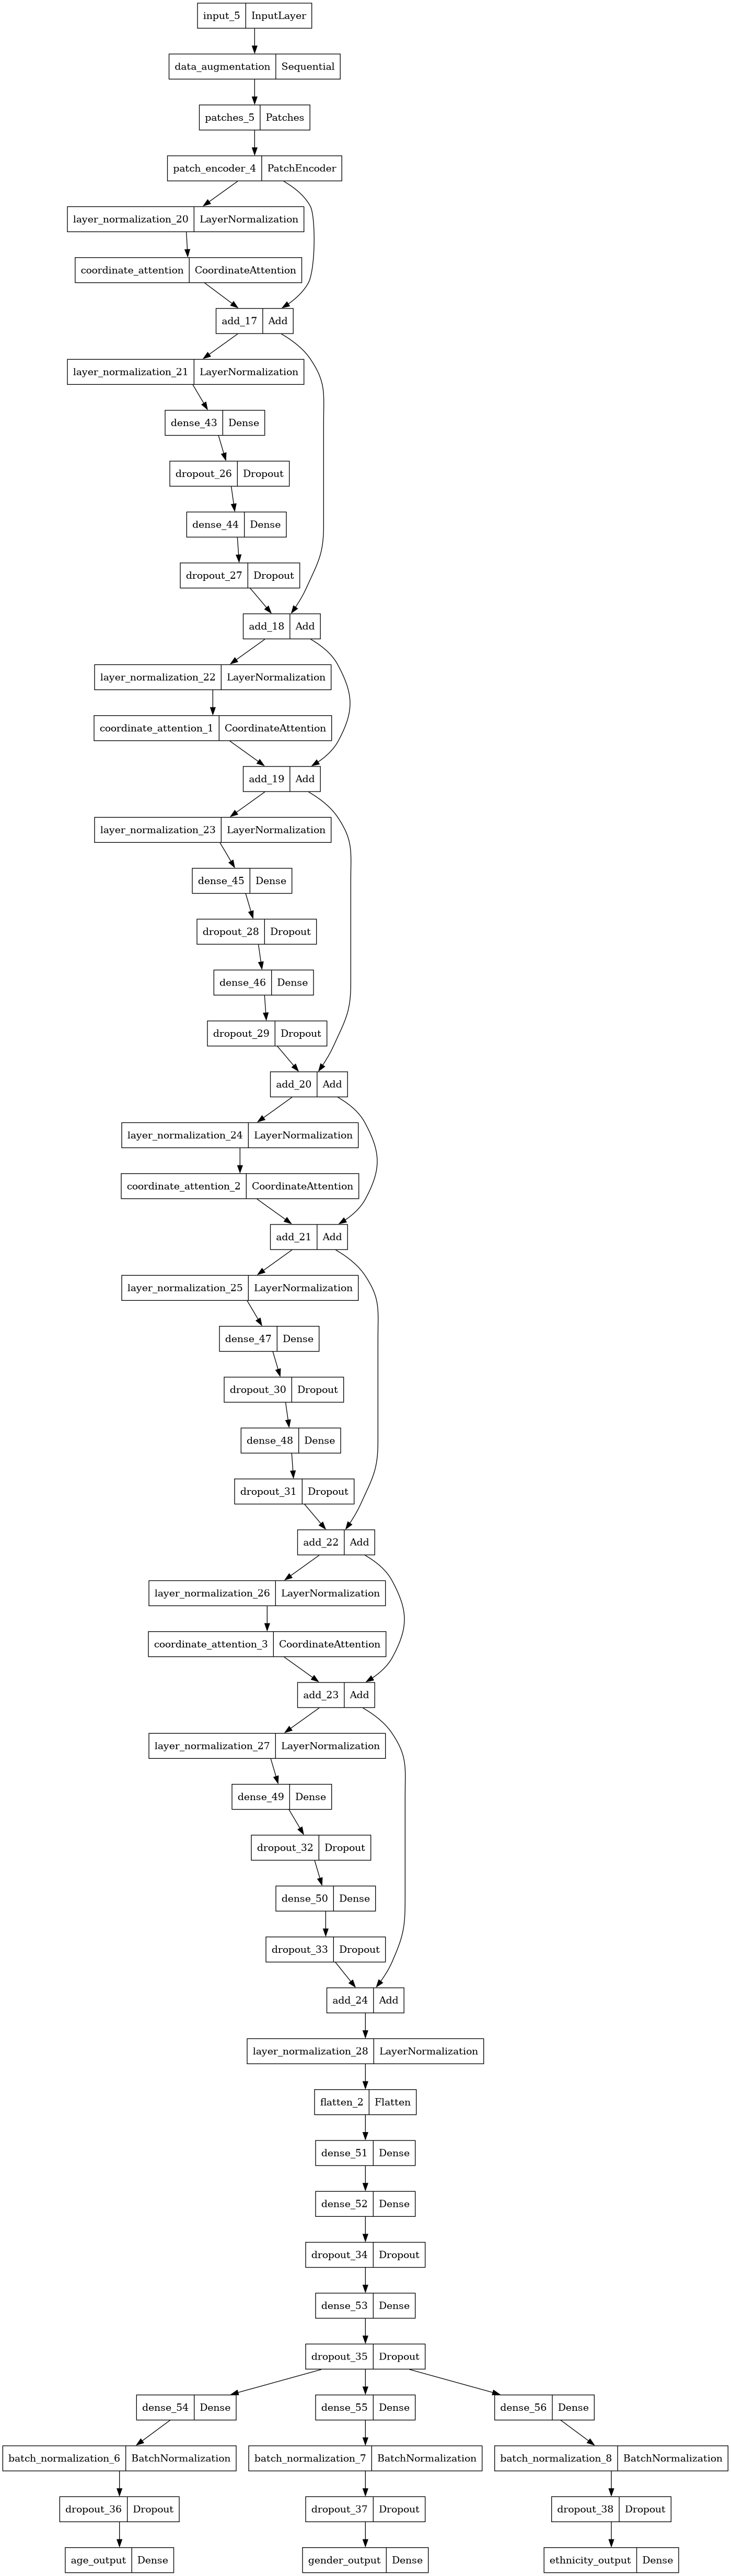

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(vit_classifier, to_file='model.png')

In [59]:
history = run_multi_task_experiment(vit_classifier)

Epoch 1/300
76/76 [==============================] - 25s 117ms/step - loss: 1309.5380 - age_output_loss: 1307.1639 - gender_output_loss: 0.7084 - ethnicity_output_loss: 1.6655 - age_output_mae: 32.4583 - gender_output_accuracy: 0.6322 - ethnicity_output_accuracy: 0.3755 - val_loss: 1404.2556 - val_age_output_loss: 1401.6700 - val_gender_output_loss: 1.0728 - val_ethnicity_output_loss: 1.5127 - val_age_output_mae: 33.2464 - val_gender_output_accuracy: 0.5787 - val_ethnicity_output_accuracy: 0.4831
Epoch 2/300
76/76 [==============================] - 8s 100ms/step - loss: 1016.9515 - age_output_loss: 1014.8525 - gender_output_loss: 0.6331 - ethnicity_output_loss: 1.4660 - age_output_mae: 28.4660 - gender_output_accuracy: 0.6585 - ethnicity_output_accuracy: 0.4348 - val_loss: 945.5306 - val_age_output_loss: 943.4957 - val_gender_output_loss: 0.6494 - val_ethnicity_output_loss: 1.3855 - val_age_output_mae: 25.9261 - val_gender_output_accuracy: 0.6654 - val_ethnicity_output_accuracy: 0.4934

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 1s 10ms/step - loss: 80.3476 - age_output_loss: 79.4086 - gender_output_loss: 0.2720 - ethnicity_output_loss: 0.6671 - age_output_mae: 6.1071 - gender_output_accuracy: 0.8802 - ethnicity_output_accuracy: 0.7663
Test age MAE: 4.04085693359375
Test gender accuracy: 0.9128193403244019
Test ethnicity accuracy: 0.9367432955741882
75/75 [==============================] - 2s 10ms/step
Gender Precision: 0.9250474383301708
Gender Recall: 0.826271186440678
Gender F1 Score: 0.8728737690241719
Ethnicity Precision: 0.6945254024140525
Ethnicity Recall: 0.6585227856574047
Ethnicity F1 Score: 0.6485872382822089
Mean Absolute Error: 6.107146343240654
Mean Squared Error: 5.040856580734733
R-squared: 0.8011107564549698


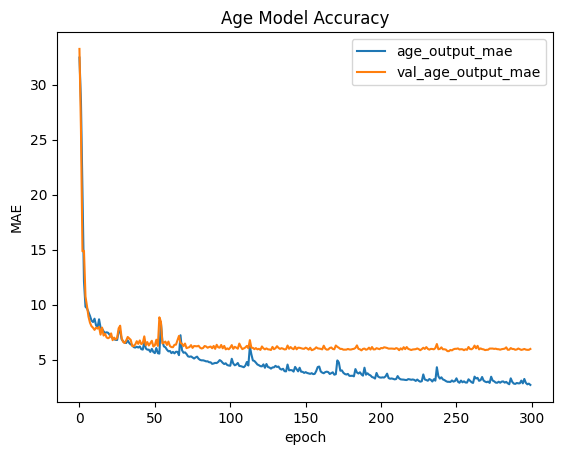

In [60]:
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.legend(['age_output_mae', 'val_age_output_mae'], loc='upper right')
plt.title('Age Model Accuracy')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.show()

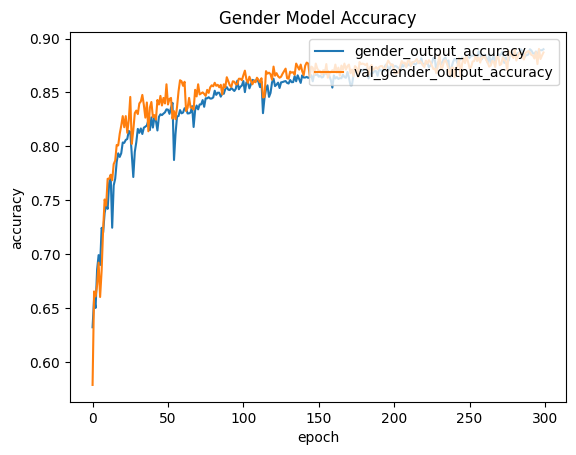

In [61]:
# Gender Accuracy Plot
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['gender_output_accuracy', 'val_gender_output_accuracy'], loc='upper right')
plt.show()

Text(0.5, 0, 'epoch')

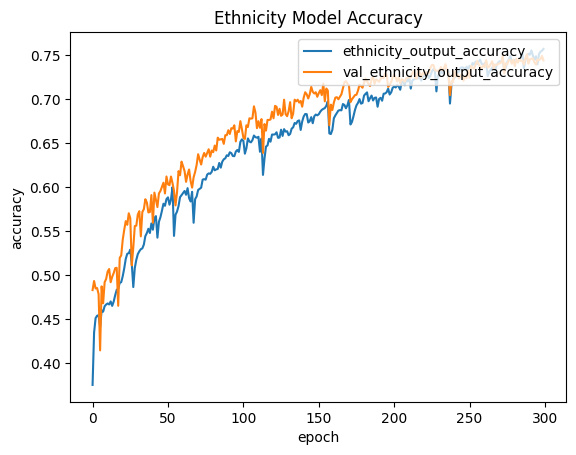

In [62]:
# Ethnicity Accuracy Plot
plt.plot(history.history['ethnicity_output_accuracy'])
plt.plot(history.history['val_ethnicity_output_accuracy'])
plt.legend(['ethnicity_output_accuracy', 'val_ethnicity_output_accuracy'], loc='upper right')
plt.title('Ethnicity Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

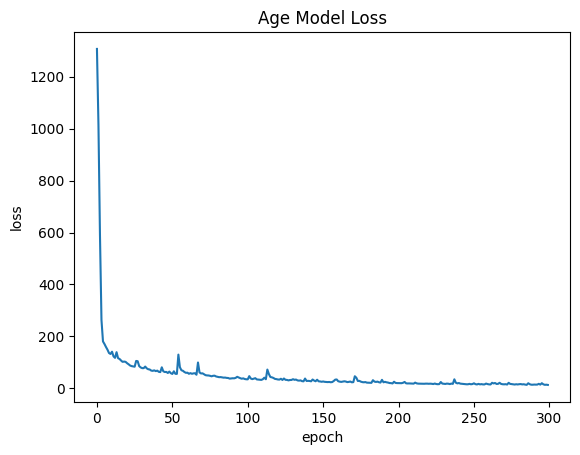

In [63]:
# Age Loss Plot
plt.plot(history.history['age_output_loss'])
plt.title('Age Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

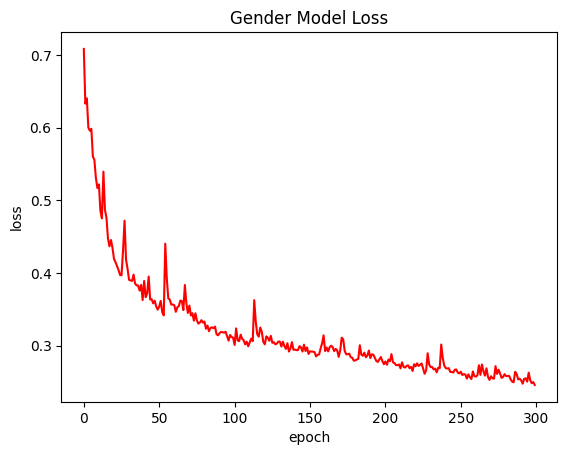

In [64]:
# Gender Loss Plot
plt.plot(history.history['gender_output_loss'], color="r")
plt.title('Gender Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

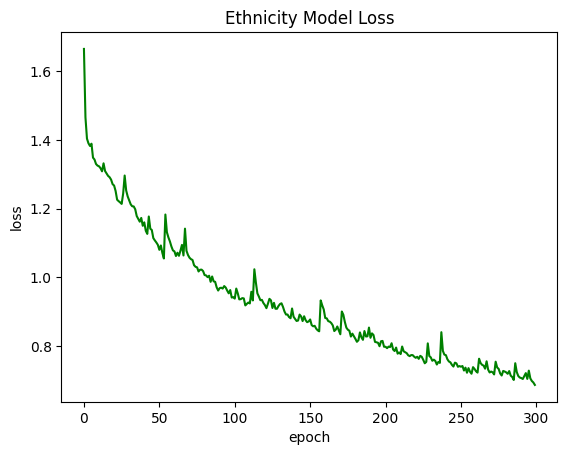

In [65]:
# Ethnicity Loss Plot
plt.plot(history.history['ethnicity_output_loss'], color="g")
plt.title('Ethnicity Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()